### **Эксперимент 5.**

Рассчитать приведенную температуру (через egt, tat, ... theta) и n1. Отбросить `egt, tat, n1, XF, HPV, NF`.

Использовать конфигурацию эксперимента 4. 

Сохранить и записать использованные константы.

Note: выяснилось, что если убрать NF то качество сильно падает. разобраться, почему

Note: 'p2e' добавляет точности

In [1]:
import pandas as pd 

fleet = ['VQ-BGU', 'VQ-BDU']

bgu = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']).dropna(subset=['egtm']).query('reportts <= \'2020-01-01\'')
bdu = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']).dropna(subset=['egtm']).query('reportts <= \'2020-01-01\'')

bgu.loc[bgu['oat'].isna(), ['oat']] = bgu.loc[bgu['oat'].isna(), :]['tat']
bdu.loc[bdu['oat'].isna(), ['oat']] = bdu.loc[bdu['oat'].isna(), :]['tat']

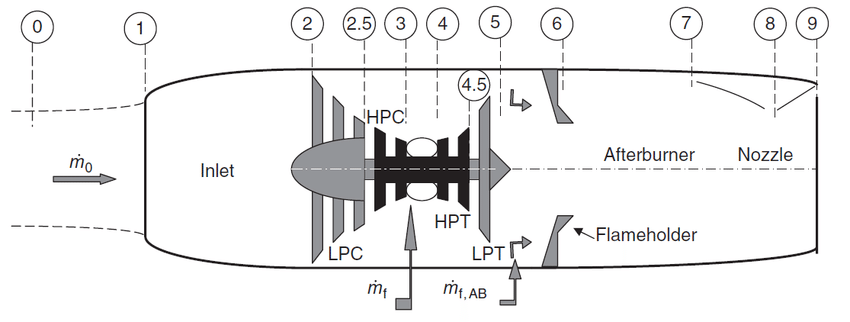

#### Подготовка

In [2]:
import pandas as pd
from utils import *
from training import *

y_cols = ['egtm']
meta_cols = ['reportts', 'acnum', 'pos']
features = ['egt', 'tat', 'oat', 'n1a', 'n2a', 'wai', 'nai', 'prv', 'alt', 'mn', 'ff', 'nf']

data = build_dataset(
  [bgu, bdu], 
  y_cols, 
  meta_cols, 
  features,
  n_back=13,
)

1.000108331667771


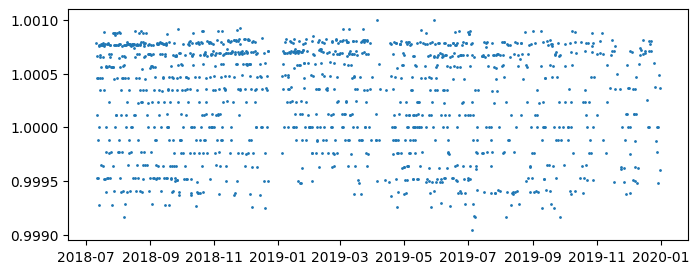

In [3]:
import matplotlib.pyplot as plt

print((data['nf'] / data['n1a']).mean())

plt.figure(figsize=(8, 3))
sub = data[(data['pos'] == 2) & (data['acnum'] == 'VQ-BDU')]
plt.scatter(sub['reportts'], sub['n1a'] / sub['nf'], s=1)
plt.show()

In [4]:
from sklearn.linear_model import LinearRegression

def train_model(X, y, model = 'linreg'):
  assert len(X) == len(y)
  train_i = int(len(X) * 75 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]

  model = LinearRegression()
  model.fit(X_train, y_train)

  predicted_train = model.predict(X_train)
  predicted_test = model.predict(X_test)

  return get_metrics(y_test, predicted_test), model, predicted_train, predicted_test, train_i, y_test

#### Baseline из эксперимента 4

In [5]:
X = data.drop(columns=(meta_cols + y_cols))
y = data['egtm']

In [6]:
base_metrics, model, baseline_train, baseline_test, train_i, y_test = train_model(X, y)

print(f'Baseline: {base_metrics}')


Baseline: {'rmse': 1.72173, 'mae': 1.41292, 'r2': 0.39271, 'mape': 0.0675}


#### Коррекция

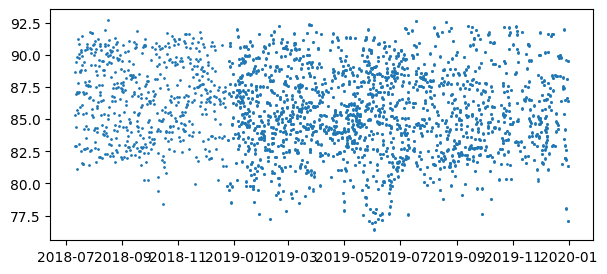

In [7]:
theta = (data['tat'] + 273.15) / 288.15
alpha = 0.5

data['n1k'] = data['n1a'] / (theta ** alpha)
plt.figure(figsize=(7, 3))
plt.scatter(data['reportts'], data['n1k'], s=1)
plt.show()

In [19]:
assert bdu['oat'].isna().sum() == 0

In [9]:

def correct(data):
  datak = data.copy()
  alpha = 0.5
  theta = (data['oat'] + 273.15) / 288.15
  delta = (data['p2e'] * 68.948) / 1013.25

  datak['nfk'] = data['nf'] / (theta ** alpha)
  datak['n1ak'] = data['n1a'] / (theta ** alpha)
  datak['n1k'] = data['n1'] / (theta ** alpha)
  datak['n2ak'] = data['n2a'] / (theta ** alpha)
  datak['egtk'] = (data['egt'] + 273.15) / theta
  datak['ffk'] = (data['ff']) / (delta * (theta ** alpha))

  return datak

In [10]:
features = ['egtk', 'tat', 'oat', 'p2e', 'n1a', 'n2a', 'wai', 'nai', 'prv', 'alt', 'mn', 'ffk', 'nf']

data = build_dataset(
  [correct(bgu), correct(bdu)], 
  y_cols, 
  meta_cols, 
  features,
  n_back=13,
)

X = data.drop(columns=(meta_cols + y_cols))
y = data['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)

print(f'EGT + FF corrections: {metrics}')


EGT + FF corrections: {'rmse': 1.68029, 'mae': 1.38424, 'r2': 0.42159, 'mape': 0.0665}


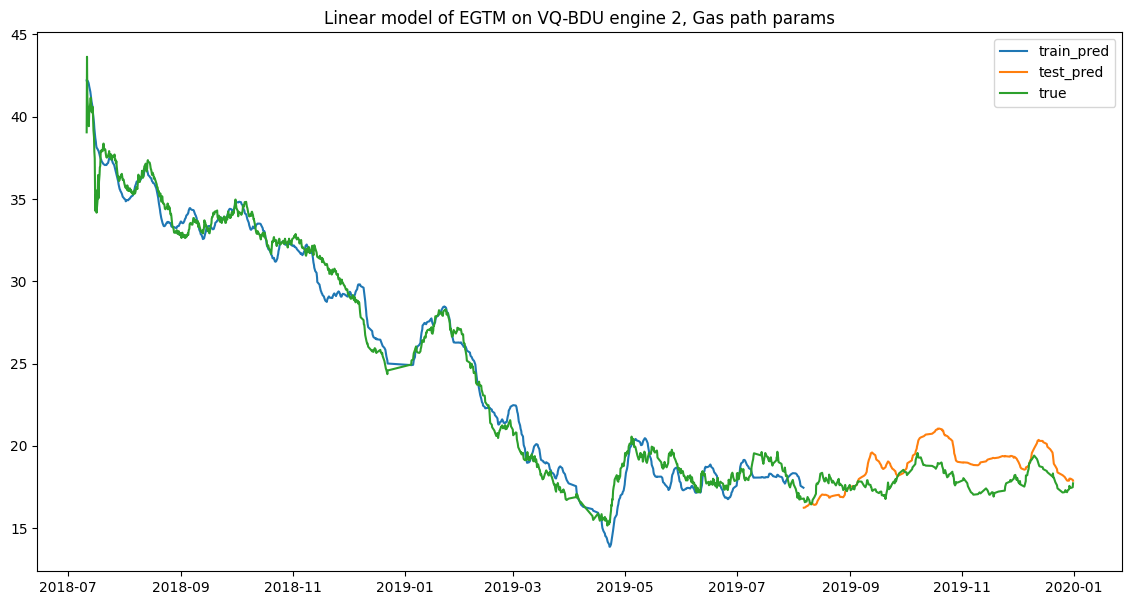

In [11]:
plot_predictions(data, 'VQ-BDU', 2, train_i, predicted_test, predicted_train)

Wow, just the egt + fuel flow correction gained us 0.1 increase in R squared!

N1, N2, NF corrections give worse results fow unknown reason

Comparison of corrections: 

In [12]:
features = ['egt', 'n1a', 'n2a', 'ff', 'nf', 'oat', 'tat', 'prv', 'alt', 'mn']

corrected = [correct(bgu), correct(bdu)]

base_metrics['name'] = 'baseline'
history = [base_metrics]

for param in ['egt', 'n1a', 'n2a', 'ff']:
  cur_features = [f'{param}k' if i == param else i for i in features]

  data = build_dataset(
    corrected,
    y_cols, 
    meta_cols, 
    cur_features,
    n_back=20,
  )

  X = data.drop(columns=(meta_cols + y_cols))
  y = data['egtm']

  metrics, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)

  metrics['name'] = param.upper()
  history.append(metrics)

pd.DataFrame(history)

,rmse,mae,r2,mape,name
0,1.72173,1.41292,0.39271,0.06750,baseline
1,1.46474,1.19420,0.56047,0.05749,EGT
2,2.02790,1.65348,0.15752,0.07903,N1A
3,1.53584,1.24746,0.51676,0.05996,N2A
4,1.60575,1.31534,0.47177,0.06335,FF


In [13]:
features = ['egtk', 'oat', 'tat', 'n1ak', 'n2ak', 'prv', 'mn', 'nfk', 'alt']

data = build_dataset(
  [correct(bgu), correct(bdu)], 
  y_cols, 
  meta_cols, 
  features,
  n_back=20,
)

X = data.drop(columns=(meta_cols + y_cols))
y = data['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)

print(f'Baseline: {metrics}')

Baseline: {'rmse': 1.38245, 'mae': 1.12562, 'r2': 0.60847, 'mape': 0.05385}


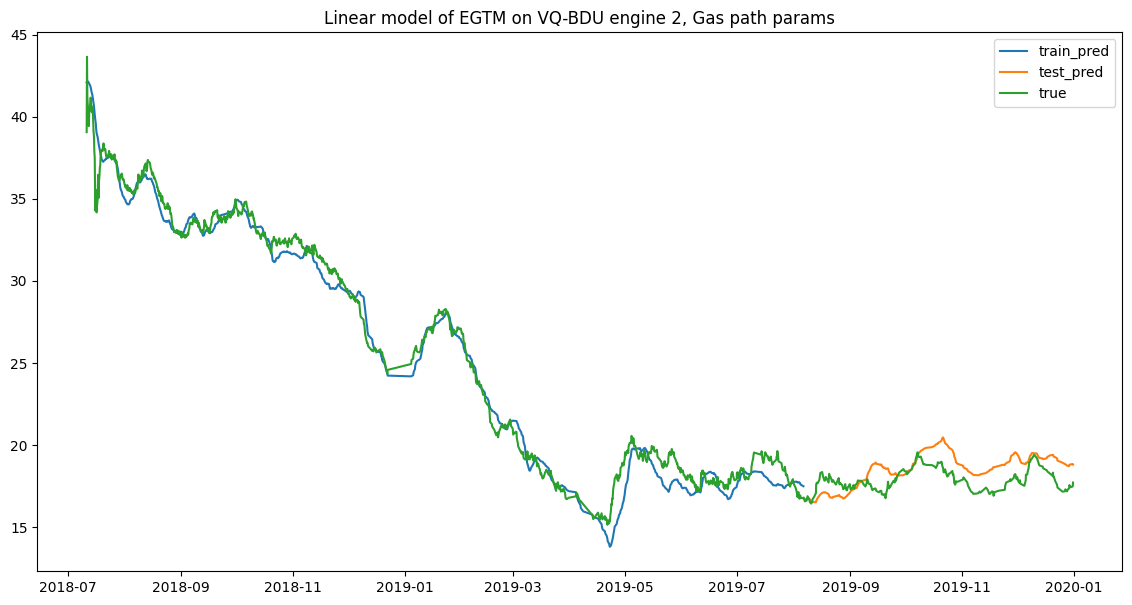

In [14]:
plot_predictions(data, 'VQ-BDU', 2, train_i, predicted_test, predicted_train, is_smooth=True)